# Mapping problem using moscot  
from dissociated scRNAseq data to spatial data 

### Import packages

In [1]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [3]:
adata_sc = sc.read('../../../../spatial_pancreas_data/preprocessed_data/dissociated_nd_annotation_l0.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 21453 × 23146
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
     var: 'n_cells'
     uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
     obsm: 'X_pca', 'X_scVI', 'X_umap'
     layers: 'counts', 'soupX_counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [4]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['ND'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 61460 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [5]:
adata_sp.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

In [6]:
cluster2annotation = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Delta' : 'Endocrine',
    'Ductal' : 'Ductal',
    'Ductal_Acinar_MUC1_AMY2A' : 'Ductal',
    'Immune' : 'Immune',
    'T-cells' : 'Immune',
    'Fibroblasts' : 'Fibroblasts',
    'Endothelial' : 'Endothelial',
    'Lymphatic' : 'Endothelial',
    'Acinar_OLFM4+' : 'Acinar', 
    'Acinar' : 'Acinar'
}

adata_sc.obs['cell_type'] = adata_sc.obs['cell_type_coarse'].map(cluster2annotation).astype('category')

adata_sc.obs['cell_type'].cat.reorder_categories(['Acinar','Alpha','Beta','Ductal','Endocrine','Endothelial',
                                                         'Fibroblasts','Immune'])#,inplace=True)

AAACCCAGTGGTCTCG-1         Acinar
AAACCCATCCATCCGT-1         Acinar
AAACGAATCGAAATCC-1         Acinar
AAACGAATCGCCTAGG-1         Acinar
AAACGCTAGGCTAACG-1         Acinar
                         ...     
TTTGTTGGTGAGTAGC-1         Acinar
TTTGTTGGTGTATACC-1         Acinar
TTTGTTGGTGTCCACG-1         Acinar
TTTGTTGTCAACTGGT-1    Fibroblasts
TTTGTTGTCGTTAGAC-1         Acinar
Name: cell_type, Length: 21453, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial', 'Fibroblasts', 'Immune']

In [7]:
adata_sc.uns['cell_type_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

In [8]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    layer='counts',
)
adata_sc

AnnData object with n_obs × n_vars = 21453 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'cell_type_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

In [9]:
sc.pp.subsample(adata_sc,fraction=0.5)
adata_sc

AnnData object with n_obs × n_vars = 10726 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'cell_type_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

Subset to a field of view to test the mapping problem 

In [10]:
adata_sp_fov_12 = adata_sp[np.isin(adata_sp.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [11]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)

Normalization to avoid technical artifacts (has to be per fov)

In [12]:
spatial = adata_sp_fov_12.obsm['spatial']
adata_sp_fov_12.obsm['spatial_norm'] = spatial - spatial.mean() / spatial.std()
adata_sp_fov_12.obsm['PCA_spatial'] = np.concatenate([adata_sp_fov_12.obsm['spatial_norm'], adata_sp_fov_12.obsm['X_pca']], axis = 1)

In [13]:
import pandas as pd
pd.crosstab(adata_sc.obs['cell_type_coarse'], adata_sc.n_obs)

col_0,10726
cell_type_coarse,
Alpha,151
Beta,213
Delta,14
Ductal,1250
Ductal_Acinar_MUC1_AMY2A,418
Immune,152
T-cells,87
Fibroblasts,362
Endothelial,61


### Preprare and solve the mapping problem with the best set of params found in v1

In [14]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['INS','GCG','SST','SOX9','KRT19','COL1A1','PECAM1','CD4'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [15]:
markers2impute

['INS', 'GCG', 'SST', 'SOX9', 'KRT19', 'COL1A1', 'PECAM1', 'CD4']

In [16]:
# Leave the control genes out of the fitting
adata_sp_fov_12_mp = adata_sp_fov_12[:,~adata_sp_fov_12.var_names.isin(markers2impute)].copy()

In [17]:
best_param = {
    'tau_a'   : 0.900000,
    'tau_b'   : 0.999000,
    'alpha'   : 0.300000,
    'epsilon' : 0.100000
}
#ins_corr    = 0.510322
#mean_corr   = 0.184891

In [18]:
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_fov_12_mp)
mp = mp.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'PCA_spatial'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = 'X_pca' #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'])

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 10726)].                                         


2024-05-14 12:28:44.110457: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


#### Imputation

In [19]:
adata_sc

AnnData object with n_obs × n_vars = 10726 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'cell_type_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

In [20]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed = []
for i in range(int(len(adata_sc.var_names)/20)):
    adata_imputed = mp.impute(var_names=adata_sc.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed.append(adata_imputed)
    del adata_imputed

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 20.527236461639404 seconds


In [21]:
import anndata as ad
adata_imputed  = ad.concat(adatas_imputed, join='outer',uns_merge='same',axis=1)
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000

In [ ]:
adata_sp_fov_12

In [22]:
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

Plotting imputed gene expression

In [23]:
markers2impute

['INS', 'GCG', 'SST', 'SOX9', 'KRT19', 'COL1A1', 'PECAM1', 'CD4']

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=['GCG','INS'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Plotting observed gene expression for hallmark hormone genes

In [ ]:
sq.pl.spatial_segment(adata_sp_fov_12,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [34]:
adata_sp_fov_12, adata_imputed

(AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'cell_type_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap', 'cell_type_max_colors'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap', 'spatial_norm', 'PCA_spatial'
   

In [35]:
adata_imputed.obs['cell_type_coarse'] = adata_sp_fov_12.obs['cell_type_coarse']

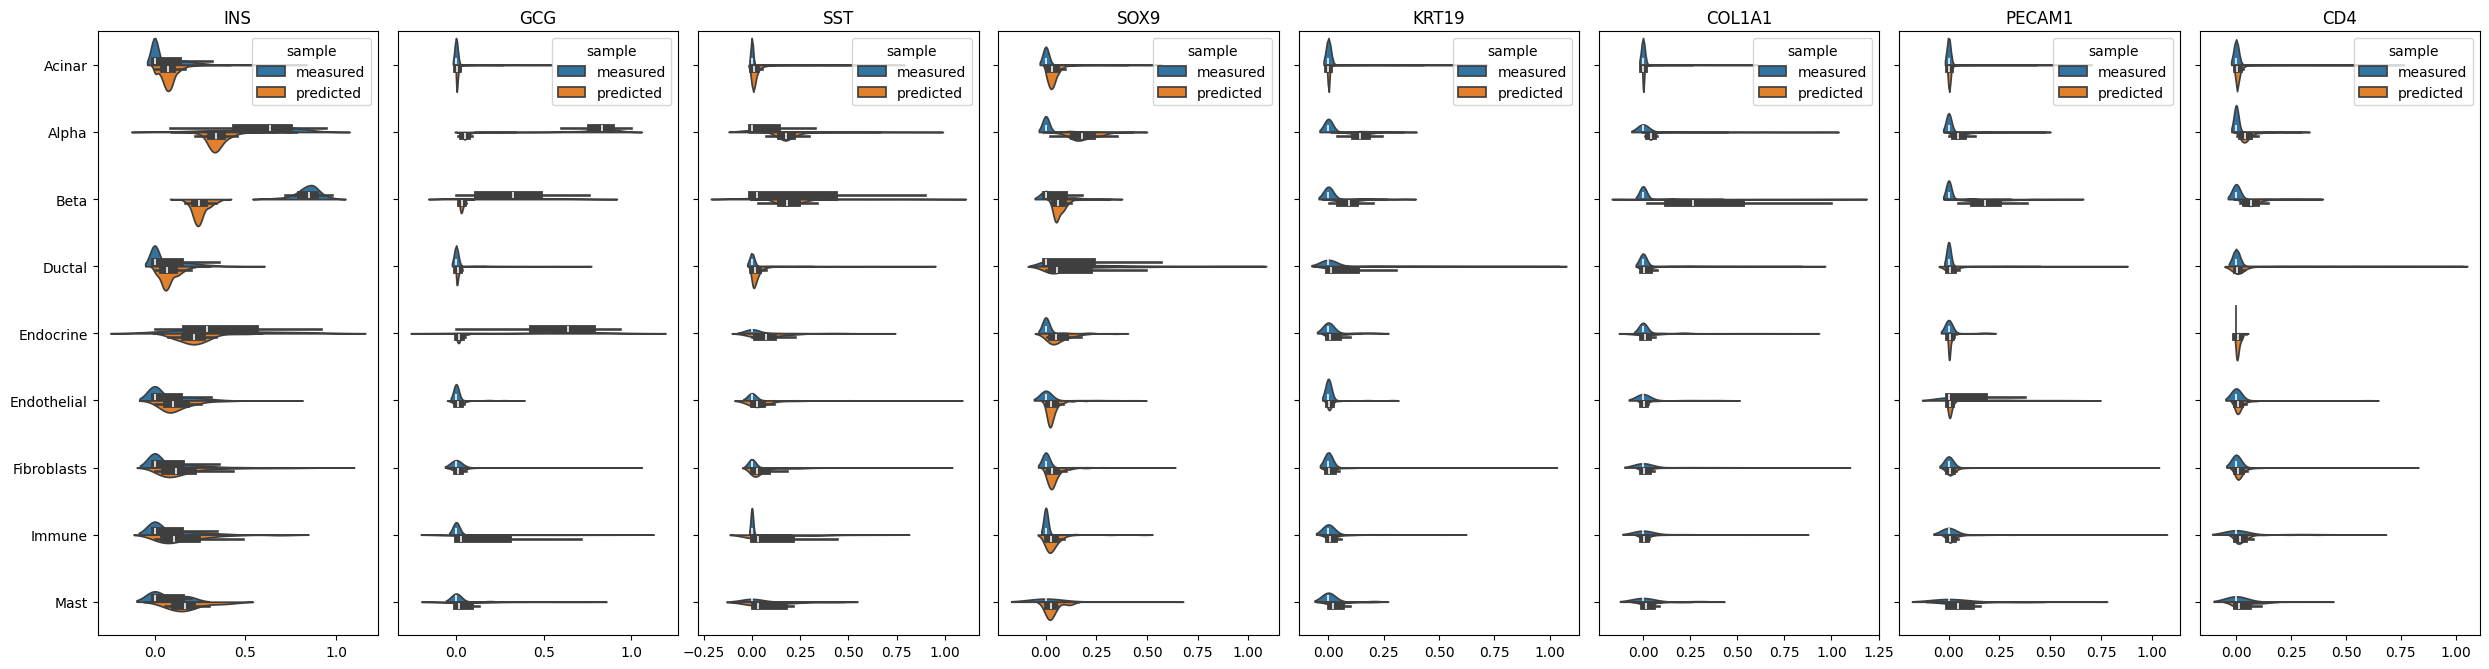

In [36]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1, len(markers2impute), figsize=(25, 6.8), sharey=True)

for i, marker in enumerate(markers2impute):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_12, [marker, "cell_type_coarse"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type_coarse"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type_coarse",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
plt.tight_layout()
plt.show()

#### Annotation mapping

In [24]:
mp[("src", "tgt")]

OTProblem[stage='solved', shape=(5208, 10726)]

In [25]:
type(adata_sc.obs.cell_type_coarse)

pandas.core.series.Series

In [26]:
adata_sc.obs.cell_type = adata_sc.obs.cell_type.astype("category")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [ ]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=1.0
%env XLA_PYTHON_CLIENT_ALLOCATOR=cub

Annotation mapping using “max” mode

In [27]:
start_time = time.time()

anno_map_max = mp.annotation_mapping(
    "max",
    "cell_type",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=3,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 46.38348603248596 seconds


In [28]:
adata_sp_fov_12.obs["cell_type_max"] = anno_map_max["cell_type"].values
adata_sp_fov_12.obs["cell_type_max"] = adata_sp_fov_12.obs["cell_type_max"].astype("category")

In [30]:
adata_sp_fov_12.uns['cell_type_max_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

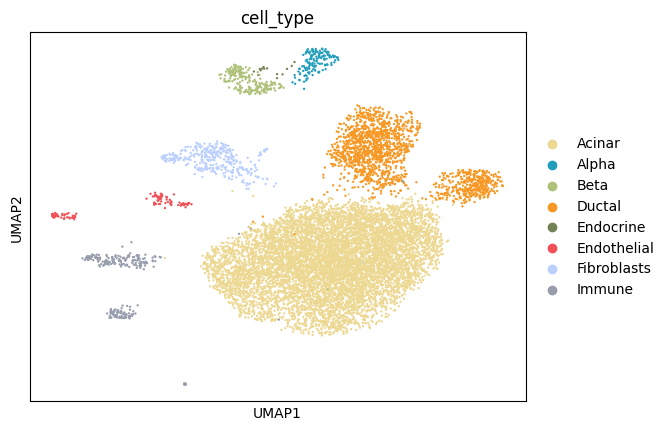

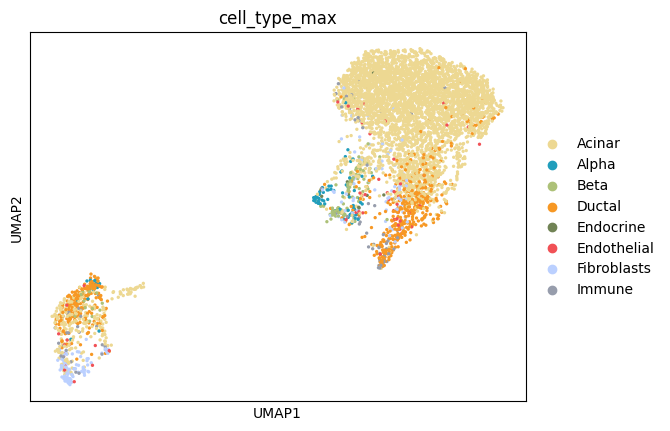

In [31]:
sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_sp_fov_12, color=["cell_type_max"])

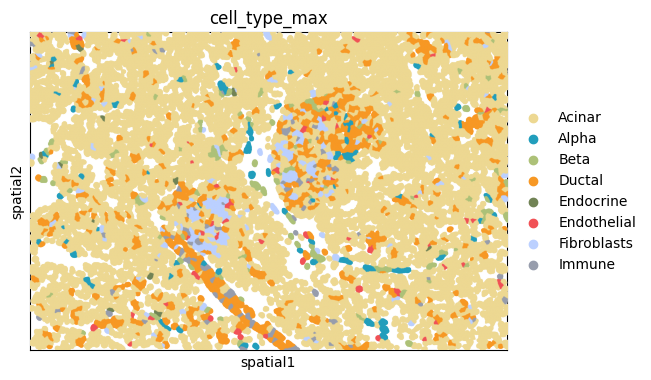

In [32]:
sq.pl.spatial_segment(adata_sp_fov_12,color='cell_type_max',size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Annotation mapping using the “sum” mode

In [40]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "cell_type",
    source="src",
    forward=False,
    batch_size=1,
)
adata_sp_fov_12.obs["cell_type_sum"] = anno_map_sum["cell_type"].values
adata_sp_fov_12.obs["cell_type_sum"] = adata_sp_fov_12.obs["cell_type_sum"].astype("category")

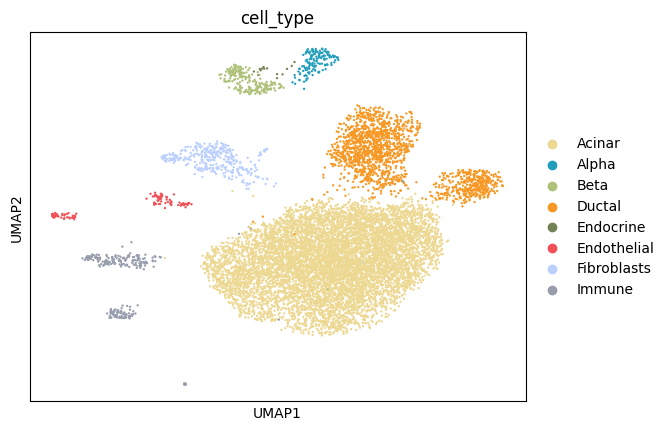

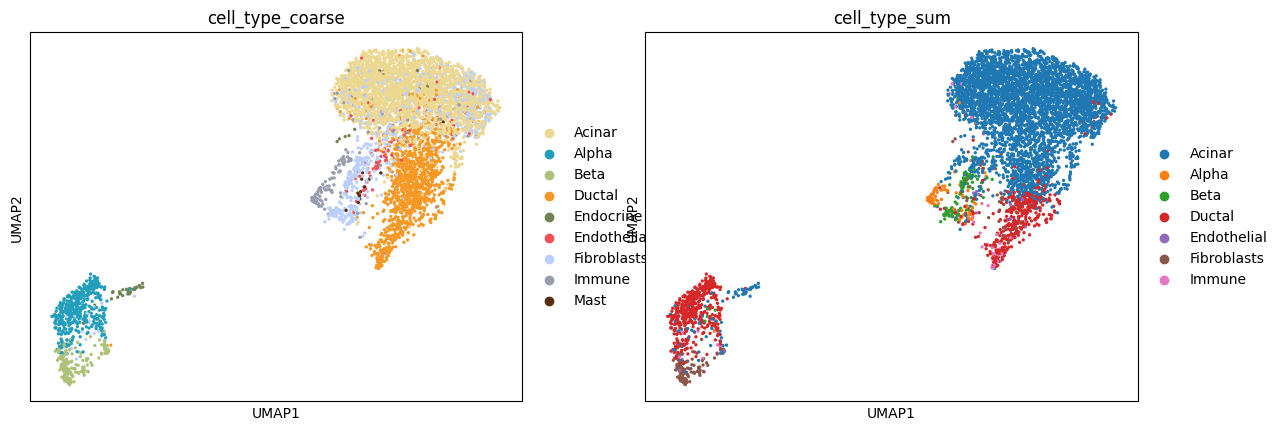

In [42]:
sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_sp_fov_12, color=["cell_type_coarse", "cell_type_sum"])

In [43]:
adata_sp_fov_12.uns['cell_type_sum_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

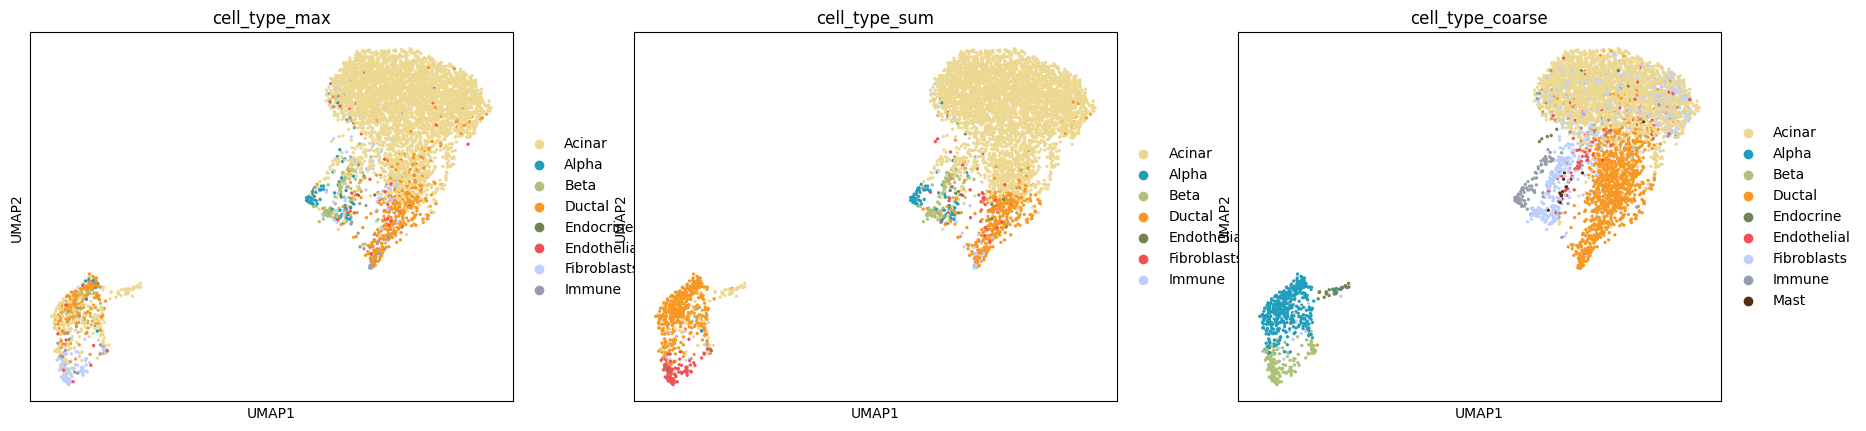

In [45]:
sc.pl.umap(adata_sp_fov_12, color=["cell_type_max", "cell_type_sum","cell_type_coarse"])

In [46]:
adata_sp_fov_12[adata_sp_fov_12.obs["cell_type_max"] == adata_sp_fov_12.obs["cell_type_sum"]].shape[
    0
] / adata_sp_fov_12.shape[0]

TypeError: Categoricals can only be compared if 'categories' are the same.